In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os
import numpy as np
from PIL import Image
from torchvision import models
from Pix2Pix import *
import torch.optim as optim
from torchvision.utils import save_image
from torch.autograd import Variable
import time
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.utils.data as data_utils
from sklearn.cluster import KMeans

### Indice
1. Obtención del dataset
2. Analisis del dataset
3. Preprocesamiento del dataset
4. Creacion del modelo
5. Entrenamiento del modelo
6. Prediccion del modelo
7. Evaluacion del modelo
8. Conclusiones

#### 1. Obtención del dataset

Para la realizacion del Caso Kaggle, he decidido buscar un dataset similar al del https://www.kaggle.com/kvpratama/pokemon-images-dataset, ya que para lo que tenia en mente necesitaba la variante shiny de cada pokemon.
Para ello he utilizado la siguiente pagina https://pokemondb.net/pokedex/shiny y he extraido las imagenes de todos los pokemons.  
Para ello he preparado un script en javascript que busca las imagenes de todos los pokemons y coge la url de la imagen de shiny y el normal:

    function getUrls(class_name) {
        imgs_normal = document.getElementsByClassName(class_name);
        str = "";
        for (let i = 0; i < imgs_normal.length; i++) {
            if (imgs_normal[i].src != undefined) {
                str += imgs_normal[i].src + '\n';
            }
        }
        return str;
    }

    normal = getUrls('shinydex-sprite-normal');
    shini = getUrls('shinydex-sprite-shiny');

Con este obtenemos lo siguiente:    

![img](imgs/web1.png)

Como se puede apreciar en la imagen podemos ver todas las url de las imagenes de los pokemons.  
A continuacion utilizando la libreria `requests` he descargado las imagenes de los pokemons en formato png, el codigo es el siguiente:

    import requests

    FILE_NORMAL = 'links_normal.txt'
    FILE_SHINY = 'links_shiny.txt'

    DOWNLOADED_FOLDER = '../dataset/'

    def downloader(file_name):
        lines = open(file_name, 'r').read().split('\n')
        for line in lines:
            if line == '': continue
            url = line.split('/')
            name_img = DOWNLOADED_FOLDER + url[-2] + "/" + url[-1]
            print(f'Downloading {name_img}...')
            r = requests.get(line)
            open(f'{name_img}', 'wb').write(r.content)
            
    if __name__ == '__main__':
        downloader(FILE_NORMAL)
        downloader(FILE_SHINY)

De esta manera conseguimos descargar las imagenes de los pokemons y separarlas en dos carpetas, una para las imagenes normales y otra para las imagenes shiny.

#### 2. Analisis del dataset

En este apartado vamos a analizar el dataset y ver las imagenes descargadas y su resolucion. Y asegurarnos de que todos los poquemosn tiene una imagen de shiny y una imagen normal.

In [89]:
DATASET_URL_NORMAL = 'dataset/Pokemon/normal/'
DATASET_URL_SHINY = 'dataset/Pokemon/shiny/'

def compare_datasets(normal_images, shiny_images):
    a = os.listdir(normal_images)
    b = os.listdir(shiny_images)
    return [x for x in a if x not in b]

def read_dataset_images(path, resize_size=(256, 256), add_white_bg=True):
    """
    Reads images from a directory and returns a list of images.
    """
    images = []
    for filename in os.listdir(path):
        png = Image.open(path + filename)
        png.load()
        # Cambiamos el formato de la imagen a RGB con el fondo a blanco
        if add_white_bg:
            background = Image.new("RGB", png.size, (255, 255, 255))
            background.paste(png, mask=png.split()[3])
            png = background
        # Redimensionamos la imagen
        png = png.resize(resize_size, Image.ANTIALIAS)
        images.append(np.array(png))
    return images

print('Incosistencias: ', len(compare_datasets(DATASET_URL_NORMAL, DATASET_URL_SHINY)))

shiny = read_dataset_images(DATASET_URL_SHINY)
normal = read_dataset_images(DATASET_URL_NORMAL)

Incosistencias:  0


Podemos ver que no tenemos incosistencias en el dataset, por lo que podemos proceder a seguir analizando el dataset.

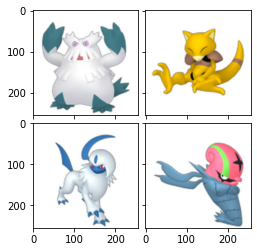

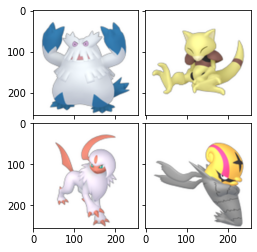

Dimension de la imagen:  (256, 256, 3)
Numero de imagenes:  895


In [78]:
def show_images(images, n_rows_cols=1):
    fig = plt.figure(figsize=(4, 4))
    grid = ImageGrid(   fig, 111,
                        nrows_ncols=(n_rows_cols, n_rows_cols),
                        axes_pad=0.1,
                    )
    for ax, im in zip(grid, images):
        ax.imshow(im)
    plt.show()

show_images(normal, 2)
show_images(shiny, 2)

print('Dimension de la imagen: ', shiny[0].shape)
print('Numero de imagenes: ', len(shiny))

Podemos observar que el dataset tiene la cantidad de 895 * 2 imagenes, las cuales estan en formato .png, pero que se han leido como jpeg y se han pasado el canal alpha a blanco. Cada imagen tiene un tamaño de 128x128x3. En la parte superior de las imagenes tenemos los pokemons normales y en la parte inferior de las imagenes tenemos los pokemons shiny.

#### 3. Preprocesamiento del dataset

En este apartado vamos a tratar diferentes preprocesamientos tipicos que se realizan en imagenes. Pero antes de hacerlo vamos a separar el dataset datos de entrenamiento y datos de test. Las imagenes de los pokemons normales sera el input del pix2pix y las imagenes de los pokemons shiny sera el target.

In [45]:
TRAIN_SIZE = round(len(normal) * 0.8)

np.random.seed(42)

np.random.shuffle(normal)
np.random.shuffle(shiny)

X_train = normal[:TRAIN_SIZE]
X_test  = normal[TRAIN_SIZE:]
Y_train = shiny[:TRAIN_SIZE]
Y_test  = shiny[TRAIN_SIZE:]

print('Numero de imagenes de entrenamiento: ', len(X_train))
print('Numero de imagenes de prueba: ', len(X_test))

Numero de imagenes de entrenamiento:  716
Numero de imagenes de prueba:  179


Una vez separados los datos de entrenamiento y test, vamos a aumentar el dataset.

In [46]:
def normalize(inimg, tgimg):
    '''
        Normalizamos el rango de la imagen para que quede entre -1 y 1
    '''
    inimg = (inimg / 127.5) - 1
    tgimg = (tgimg / 127.5) - 1
    return inimg.astype(float), tgimg.astype(float)

def flip_image_vertical(inimg, tgimg):
    '''
        Flipamos la imagen
    '''
    inimg = np.flip(inimg, 1)
    tgimg = np.flip(tgimg, 1)
    return inimg, tgimg

def flip_image_horizontal(inimg, tgimg):
    '''
        Flipamos la imagen
    '''
    inimg = np.flip(inimg, 0)
    tgimg = np.flip(tgimg, 0)
    return inimg, tgimg

def to_tensor(X):
    new = []
    trans = transforms.ToTensor()
    for x in X: new.append(trans(x))
    return torch.Tensor(new)

def change_axis(X, y):
    new_X = []
    new_y = []
    for x, y in zip(X, y):
        new_X.append(np.transpose(x, (2, 0, 1)))
        new_y.append(np.transpose(y, (2, 0, 1)))
    return new_X, new_y

def data_augmentation(X, y):
    new_X = []
    new_y = []
    
    for i in range(len(X)-2):
        x_t, y_t = flip_image_vertical(X[i], y[i])
        new_X.append(x_t)
        new_y.append(y_t)
        
        x_t, y_t = flip_image_horizontal(X[i+1], y[i+1])
        new_X.append(x_t)
        new_y.append(y_t)
        
        x_t, y_t = flip_image_vertical(X[i+2], y[i+2])
        x_t, y_t = flip_image_horizontal(x_t, y_t)
        new_X.append(x_t)
        new_y.append(y_t)

    return new_X, new_y

for i in range(len(X_train)):
    X_train[i], Y_train[i] = normalize(X_train[i], Y_train[i])

X_train, Y_train = data_augmentation(X_train, Y_train)
X_train, Y_train = change_axis(X_train, Y_train)

X_train = torch.Tensor(np.stack(X_train))
Y_train = torch.Tensor(np.stack(Y_train))

train = data_utils.TensorDataset(X_train, Y_train)
my_dataloader = DataLoader(train, shuffle=True, batch_size=1)

Podemos ver que tenemos ahora 2141 imagenes de entrenamiento despues de realizar el aumento.

#### 4. Creacion del modelo

In [18]:
cuda = True if torch.cuda.is_available() else False

# Loss functions
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 100

# Calculate output of image discriminator (PatchGAN)
patch = (1, 256 // 2 ** 4, 256 // 2 ** 4)

# Initialize generator and discriminator
generator = GeneratorUNet()
discriminator = Discriminator()

generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    criterion_GAN.cuda()
    criterion_pixelwise.cuda()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
# ----------
#  Training
# ----------
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
#torch.cuda.empty_cache()
prev_time = time.time()

for epoch in range(1, 4):
    for i, batch in enumerate(my_dataloader):

        real_A = Variable(batch[1].type(Tensor).cuda()).cuda()
        real_B = Variable(batch[0].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *patch))), requires_grad=False).cuda()
        fake = Variable(Tensor(np.zeros((real_A.size(0), *patch))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # GAN loss
        fake_B = generator(real_A)
        pred_fake = discriminator(fake_B, real_A)
        loss_GAN = criterion_GAN(pred_fake, valid)
        # Pixel-wise loss
        loss_pixel = criterion_pixelwise(fake_B, real_B)

        # Total loss
        loss_G = loss_GAN + lambda_pixel * loss_pixel

        loss_G.backward()

        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Real loss
        pred_real = discriminator(real_B, real_A)
        loss_real = criterion_GAN(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(fake_B.detach(), real_A)
        loss_fake = criterion_GAN(pred_fake, fake)

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake)

        loss_D.backward()
        optimizer_D.step()

        # --------------
        #  Log Progress
        # --------------

    if 1 != -1 and epoch % 1 == 0:
        # Save model checkpoints
        torch.save(generator.state_dict(), "checkpoints/generator_%d.pth" % (epoch))
        torch.save(discriminator.state_dict(), "checkpoints/discriminator_%d.pth" % (epoch))

Una vez creado el modelo realizamos el entrenamiento del modelo.

Como el modelo no ha funcionado correctamente (por falta de tiempo de entrenamiento y que el generador, no bajaba el error de manera rapida, me he dispuesto a realizar otro tipo de problema).

Para ello he consegido un dataset de Digimon que se encontraba en este repositorio: https://github.com/DeathReaper0965/Digimon-Generator-GAN/blob/master/Digimon.zip y he limpiado a mano, aquellos que no tenian el mismo estilo. Por lo que nos hemos quedado con la misma cantidad de pokemon y digimos. Para este caso solamente utilizare el dataset de pokemon normal.

In [90]:
DATASET_URL_DIGIMON = 'dataset/Digimon/'

pokemon = read_dataset_images(DATASET_URL_NORMAL, (128, 128), True)
digimon = read_dataset_images(DATASET_URL_DIGIMON, (128, 128), False)

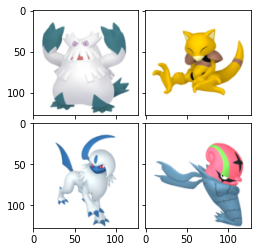

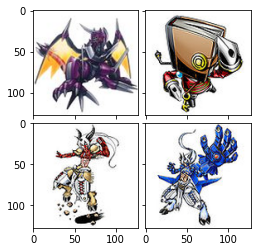

Dimension de la imagen (Pokemon):  (128, 128, 3)
Numero de imagenes (Pokemon):  895
Dimension de la imagen (Digimon):  (128, 128, 3)
Numero de imagenes (Digimon):  895


In [91]:
show_images(pokemon, 2)
show_images(digimon, 2)

print('Dimension de la imagen (Pokemon): ', pokemon[0].shape)
print('Numero de imagenes (Pokemon): ', len(pokemon))

print('Dimension de la imagen (Digimon): ', digimon[0].shape)
print('Numero de imagenes (Digimon): ', len(digimon))

#### Creamos los dataset

In [97]:
# Agrupamos en el mismo datset las imagenes de pokemon y digimon

X = pokemon + digimon

y = [0] * len(pokemon) + [1] * len(digimon)

dataset = list(zip(X, y))

np.random.seed(42)
np.random.shuffle(dataset)

X_train, y_train = zip(*dataset[:int(TRAIN_SIZE * len(dataset))])
X_test, y_test = zip(*dataset[int(TRAIN_SIZE * len(dataset)):])

In [99]:
# Normalizamos las imagenes
X_train = np.stack(X_train)
X_train = torch.Tensor(X_train)
TensorDataset(X_train, y_train)

AttributeError: 'tuple' object has no attribute 'size'

#### Definiendo el modelo

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 5)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32*53*53, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 2)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 32 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.softmax(self.fc3(x))
        return x

In [15]:
# create a complete CNN
model = Net()
print(model)
train_on_gpu = torch.cuda.is_available()
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.003, momentum= 0.9)

In [ ]:
# number of epochs to train the model
n_epochs = 5 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss